In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from nltk.cluster import KMeansClusterer
import nltk

from node2vec import Node2Vec

sns.set_style('whitegrid')

## 0. Functions

In [28]:
def count_scores(labels, clusters):
    f1_micro = metrics.f1_score(labels,clusters,average='micro')
    adj_score = metrics.adjusted_rand_score(labels,clusters)
    return f1_micro, adj_score

def make_graph(labels, edges):
    G = nx.Graph()
    G.add_nodes_from(labels['node'])

    for i, row in edges.iterrows():
        G.add_edge(row['from'],row['to'], weight=1)
    return G 

def count_embeddings(G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    n2v = Node2Vec(G, 
               dimensions = dimensions, 
               walk_length = walk_length,
               num_walks = num_walks,
               p = p,
               q = q,
               workers = workers
              )
    model = n2v.fit(window = window, 
                          min_count = min_count,
                          seed = seed
                         )
    model_nodes = list(model.wv.vocab)

    return model,model_nodes

def write_to_file(res,param):
    now = datetime.now()
    current_time = now.strftime('%Y%m%d_emails_'+param)
    filename = '../results/' + current_time + '.csv'
    res.to_csv(filename)

In [3]:
def evaluate(G, labels,
            dimensions=128,
            walk_length=80,
            num_walks=10,
            p=1.0,
            q=1.0,
            workers=4,
            window=10,
            min_count=1,
            seed=0):
    model,model_nodes = count_embeddings(G,
                                         labels,dimensions,
                                         walk_length,num_walks,p,q,workers,
                                         window,min_count,
                                         seed)
    # the list of known labels inthe model nodes order
    known_labels = []
    for i in model.wv.index2word:
        known_labels.append(labels.loc[int(i)]['label'])
    
    # keys as centroids for clustering - the first node of each cluster
    keys = []
    labels_list = labels['label'].unique()
    for i in labels_list:
        keys.append(list(labels[labels['label']==i]['node'])[0])
    n_clusters = len(labels_list)
    
    # init kmeans centroids with keys
    kmean_init = []    
    for i in keys:
        kmean_init.append(model.wv[str(i)])
    init = np.array(kmean_init)
    # clustering
    km = KMeans(n_clusters=n_clusters,init=init).fit_predict(model.wv.vectors)
    km_map = dict(zip(model.wv.index2word, km))
    
    f1_micro, adj_score = count_scores(known_labels, km)
    
    return f1_micro, adj_score

## 1. Data read

In [4]:
edges = pd.read_csv('../data/emails/edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/emails/labels.csv', header=None, 
                     names=('node','label'))
labels = labels.sort_values(by='label')

labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

G = make_graph(labels, edges)

## 2. Parametres sensitivity

In [5]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'windddow','min_count',
                            'f1_micro','adj_rand'])

In [6]:
# parametres sensitivity studying
outer_count = 1
for dimensions in [2,4,8,16,32,64,128]:
    print('outer: ', outer_count)
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            # evaluate 9 times and take the mean() of the scores
                            inner_count = 1
                            for _ in range(0,9):
                                print('inner_count: ', inner_count)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)
                                inner_count+=1

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            outer_count+=1
                            
write_to_file(res,'dimensions')

outer:  1
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.45it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:20<00:00, 48.54it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.36it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.10it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.93it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.61it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 74.08it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.55it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.02it/s]


outer:  2
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.61it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.26it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.09it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.31it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.29it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.83it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.48it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.53it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.45it/s]


outer:  3
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.96it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.77it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.22it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.61it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.18it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.95it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.87it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.58it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.41it/s]


outer:  4
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.11it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.45it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.75it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.24it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.26it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.43it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.06it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.09it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.09it/s]


outer:  5
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.44it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.14it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.29it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.93it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.73it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.13it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.82it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.89it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.74it/s]


outer:  6
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.57it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.23it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.00it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.47it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.61it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.19it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.02it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.12it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.97it/s]


outer:  7
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.89it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.42it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 77.19it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.15it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.95it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.11it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.61it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.46it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.42it/s]


In [12]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [2,4,8,16,32,64,80]:
        print('walk_length: ', walk_length)
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            # evaluate 10 times and take the mean() of the scores
                            inner_count = 1
                            for _ in range(0,10):
                                print('inner_count: ', inner_count)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)
                                inner_count+=1

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'walk_length_mean')

outer:  1
inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.31it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.20it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:36<00:00, 27.78it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.29it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:39<00:00, 25.37it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 30.83it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.58it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:38<00:00, 26.10it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.38it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 31.35it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 33.42it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.08it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.90it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.36it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.01it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.38it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 33.55it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.35it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.75it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.98it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 31.78it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.28it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.54it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.38it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.64it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 35.97it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.88it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.35it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.11it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.37it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.18it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.49it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.55it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.56it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 35.91it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.77it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 35.95it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.00it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.72it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.76it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 35.92it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.82it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:34<00:00, 29.53it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.97it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.69it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 31.03it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.51it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.50it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.03it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.67it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 33.81it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 31.84it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:36<00:00, 27.87it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:33<00:00, 29.93it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 33.99it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.36it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:33<00:00, 30.37it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 32.46it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.34it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 37.11it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.74it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.75it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 32.54it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.93it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.52it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.14it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:33<00:00, 29.91it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:34<00:00, 29.03it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 31.01it/s]


inner_count:  10


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.56it/s]


In [20]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [80]:
        for num_walks in [2,4,6,8,10,12]:
            print('num_walks: ', num_walks)
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            # evaluate 10 times and take the mean() of the scores
                            for i in range(0,10):
                                print('inner_count: ', i)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'num_walks_mean')

num_walks:  2
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 32.14it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.13it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 31.83it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.23it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.28it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.51it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.07it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.50it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 33.17it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.76it/s]


num_walks:  4
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.40it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.78it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.89it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.33it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.87it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.19it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.65it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.46it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 31.60it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:33<00:00, 29.63it/s]


num_walks:  6
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.61it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.40it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.39it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 32.04it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:33<00:00, 30.42it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 30.64it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 31.12it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 33.11it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 37.18it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.22it/s]


num_walks:  8
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.57it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.83it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:37<00:00, 27.16it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:36<00:00, 27.51it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:31<00:00, 32.18it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:32<00:00, 30.90it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.56it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.00it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.55it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.80it/s]


num_walks:  10
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.56it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 33.61it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.40it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.20it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.67it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:35<00:00, 28.09it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.17it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.06it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.82it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.70it/s]


num_walks:  12
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.61it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.49it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.43it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.09it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:30<00:00, 32.79it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 34.78it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 33.67it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.31it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 63.69it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.13it/s]


In [29]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [0.25,0.5,1.0,2.0,4.0]:
                print('p: ', p)
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            # evaluate 10 times and take the mean() of the scores
                            for i in range(0,10):
                                print('inner_count: ', i)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'p_mean')

p:  0.25
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 66.81it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 67.02it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:16<00:00, 59.79it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.94it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:11<00:00, 84.40it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:11<00:00, 84.60it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:11<00:00, 85.67it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.54it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.38it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 70.68it/s]


p:  0.5
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 68.38it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.62it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.43it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.27it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.47it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.10it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.71it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 77.03it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.22it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.04it/s]


p:  1.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 77.04it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.44it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.78it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.66it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.29it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.71it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.10it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.69it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.26it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.52it/s]


p:  2.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.87it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.46it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.36it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.38it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.44it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.36it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.58it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.36it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 70.06it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.48it/s]


p:  4.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.87it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.96it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.75it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.47it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.32it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.76it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.84it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.38it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.87it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.03it/s]


In [30]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.]:
                for q in [0.25,0.5,1.0,2.0,4.0]:
                    print('q: ', q)
                    for window in [10]:
                        for min_count in [1]:
                            # evaluate 10 times and take the mean() of the scores
                            for i in range(0,10):
                                print('inner_count: ', i)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'q_mean')

q:  0.25
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.65it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.74it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.35it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.76it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.25it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.38it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.99it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.82it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.36it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 66.03it/s]


q:  0.5
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:22<00:00, 44.23it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.42it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.40it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.53it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.83it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:19<00:00, 52.12it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.44it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 65.59it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.36it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.42it/s]


q:  1.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 75.79it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.46it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 71.82it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:16<00:00, 60.79it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.94it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 72.26it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.71it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 77.26it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.66it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.14it/s]


q:  2.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 71.43it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.05it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 74.34it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.87it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.89it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.95it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 63.38it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.77it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.86it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.02it/s]


q:  4.0
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.06it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 74.72it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 71.87it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.43it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.27it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.60it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.97it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:20<00:00, 48.93it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:17<00:00, 58.13it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 83.29it/s]


In [31]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.]:
                for q in [1.]:
                    for window in [2,4,6,8,10,12]:
                        print('window: ', window)
                        for min_count in [1]:
                            # evaluate 10 times and take the mean() of the scores
                            for i in range(0,10):
                                print('inner_count: ', i)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'window_mean')

window:  2
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.28it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 70.84it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 72.63it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.62it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.47it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.52it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.82it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.08it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.94it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 73.83it/s]


window:  4
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.61it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.10it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.40it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.66it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.21it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.29it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.95it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.90it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.91it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.52it/s]


window:  6
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.40it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.68it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.12it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.98it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.45it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.41it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.18it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.71it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.45it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.38it/s]


window:  8
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.94it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.99it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.95it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.86it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.45it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.58it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.11it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.79it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.87it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.46it/s]


window:  10
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.15it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.90it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.34it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.04it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.49it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.52it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.64it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 81.20it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 77.67it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 77.05it/s]


window:  12
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.37it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 76.85it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.65it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 78.34it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 71.57it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 80.01it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 79.83it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:12<00:00, 82.59it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 66.67it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.81it/s]


In [32]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'f1_micro','adj_rand'])
# parametres sensitivity studying
for dimensions in [32]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.]:
                for q in [1.]:
                    for window in [10]:
                        for min_count in [1,2,3,4,5]:
                            print('min_count: ', min_count)
                            # evaluate 10 times and take the mean() of the scores
                            for i in range(0,10):
                                print('inner_count: ', i)
                                iter_res = pd.DataFrame(columns=['f1_micro','adj_rand'])
                                f1_micro, adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count)
                                iter_res = iter_res.append({
                                    'f1_micro':f1_micro,
                                    'adj_rand':adj_rand
                                },ignore_index=True)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'f1_micro':iter_res['f1_micro'].mean(),
                                         'adj_rand':iter_res['adj_rand'].mean()},
                                        ignore_index=True)
                            
write_to_file(res,'min_count_mean')

min_count:  1
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 40.96it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.29it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:22<00:00, 45.02it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.95it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.71it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 38.61it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 37.17it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:28<00:00, 35.45it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:23<00:00, 42.02it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.22it/s]


min_count:  2
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.89it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.75it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.27it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:23<00:00, 42.20it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.72it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 38.20it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 40.06it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 40.42it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.74it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.28it/s]


min_count:  3
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.98it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.90it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.33it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 36.49it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.97it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 38.48it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:26<00:00, 37.88it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 41.46it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.49it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 38.86it/s]


min_count:  4
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 40.73it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:23<00:00, 42.46it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 40.11it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 40.15it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 38.98it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.35it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 37.14it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 41.56it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:24<00:00, 41.74it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:23<00:00, 42.04it/s]


min_count:  5
inner_count:  0


Computing transition probabilities: 100%|██████████| 1005/1005 [00:25<00:00, 39.44it/s]


inner_count:  1


Computing transition probabilities: 100%|██████████| 1005/1005 [00:21<00:00, 46.56it/s]


inner_count:  2


Computing transition probabilities: 100%|██████████| 1005/1005 [00:29<00:00, 34.56it/s]


inner_count:  3


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 67.93it/s]


inner_count:  4


Computing transition probabilities: 100%|██████████| 1005/1005 [00:27<00:00, 37.08it/s]


inner_count:  5


Computing transition probabilities: 100%|██████████| 1005/1005 [00:16<00:00, 60.72it/s]


inner_count:  6


Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 69.56it/s]


inner_count:  7


Computing transition probabilities: 100%|██████████| 1005/1005 [00:13<00:00, 72.03it/s]


inner_count:  8


Computing transition probabilities: 100%|██████████| 1005/1005 [00:15<00:00, 65.15it/s]


inner_count:  9


Computing transition probabilities: 100%|██████████| 1005/1005 [00:16<00:00, 61.71it/s]


## 3.Visualization of the results

In [35]:
res_dim = pd.read_csv('../results/20200422-114327_emails_dimensions_mean.csv')
res_walk_length = pd.read_csv('../results/20200422-144017_emails_walk_length_mean.csv')
res_num_walks = pd.read_csv('../results/20200422-162751_emails_num_walks_mean.csv')
res_p = pd.read_csv('../results/20200422_emails_p_mean.csv')
res_q = pd.read_csv('../results/20200422_emails_q_mean.csv')
res_window = pd.read_csv('../results/20200422_emails_window_mean.csv')
res_min_count = pd.read_csv('../results/20200423_emails_min_count_mean.csv')

In [36]:
x1 = res_dim['dimensions']
y1_1 = res_dim['f1_micro'].tolist()
y1_2 = res_dim['adj_rand'].tolist()

x2 = res_walk_length['walk_length']
y2_1 = res_walk_length['f1_micro'].tolist()
y2_2 = res_walk_length['adj_rand'].tolist()

x3 = res_num_walks['num_walks']
y3_1 = res_num_walks['f1_micro'].tolist()
y3_2 = res_num_walks['adj_rand'].tolist()

x4 = res_p['p']
y4_1 = res_p['f1_micro'].tolist()
y4_2 = res_p['adj_rand'].tolist()

x5 = res_q['q']
y5_1 = res_q['f1_micro'].tolist()
y5_2 = res_q['adj_rand'].tolist()

x6 = res_window['window']
y6_1 = res_window['f1_micro'].tolist()
y6_2 = res_window['adj_rand'].tolist()

x7 = res_min_count['min_count']
y7_1 = res_min_count['f1_micro'].tolist()
y7_2 = res_min_count['adj_rand'].tolist()

Text(0, 0.5, 'score')

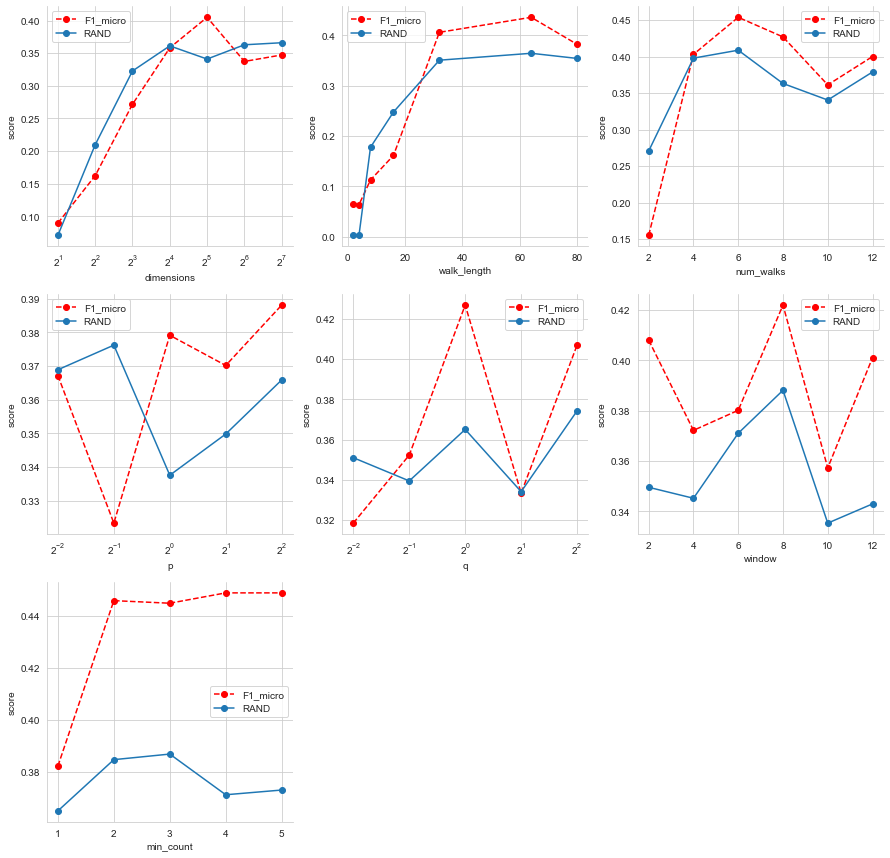

In [38]:
plt.figure(figsize=[15,15])

plt.subplot(331)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x1,y1_1,'ro--', label='F1_micro')
plt.plot(x1,y1_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('dimensions')
plt.ylabel('score')

plt.subplot(332)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x2,y2_1,'ro--', label='F1_micro')
plt.plot(x2,y2_2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('walk_length')
plt.ylabel('score')

plt.subplot(333)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x3,y3_1,'ro--', label='F1_micro')
plt.plot(x3,y3_2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('num_walks')
plt.ylabel('score')

plt.subplot(334)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x4,y4_1,'ro--', label='F1_micro')
plt.plot(x4,y4_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('p')
plt.ylabel('score')

plt.subplot(335)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x5,y5_1,'ro--', label='F1_micro')
plt.plot(x5,y5_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('q')
plt.ylabel('score')

plt.subplot(336)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x6,y6_1,'ro--', label='F1_micro')
plt.plot(x6,y6_2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(337)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x7,y7_1,'ro--', label='F1_micro')
plt.plot(x7,y7_2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('min_count')
plt.ylabel('score')